## Exercises : data visualisation

In the previous session's exercises on `pandas` we used the *Natural gas consumption in the Netherlands* dataset [CBS Open data StatLine](https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS).  We will continue with the same dataset here for visualisation. We repeat the solution for the last exercise to include the `term` and `date` in our dataframe:


In [4]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

cbs = pd.read_csv("../07_pd/data/00372eng_UntypedDataSet_17032023_161051.csv",sep=";")

def to_ts(s):
    """
    Apply the following timestamp format for each term {JJ,KW,MM}:

    JJ : yyyyJJ00 => 31-12-yyyy
    KW : yyyyKWdd => 01: 1-1-yyyy to 31-3-yyyy
                     02: 1-4-yyyy to 30-6-yyyy
                     03: 1-7-yyyy to 30-9-yyyy
                     04: 1-10-yyyy to 31-12-yyyy
    MM : yyyyMMdd => 1-xx-yyyy

    :param s: {year,term,idx}
    :return: Timestamp
    """

    def last_day(ts):
        """
        Given a timestamp find the last day of the month. The number of days in the month can be
        calculated by subtracting next month from this month on the same day and the same year.

        :param ts:
        :return: Number of days in the month (int).
        """
        return (ts.replace(year=ts.year + (ts.month == 12), month=(ts.month % 12) + 1) - ts).days

    # _main_
    year_, term, idx = s
    match term:
        case 'JJ':
            day_, month_ = 31, 12
            return pd.Timestamp(year=year_, month=month_, day=day_)
        case 'KW':
            day_, month_ = [(31,3),(30,6),(30,9),(31,12)][idx-1]
            return pd.Timestamp(year=year_, month=month_, day=day_)
        case 'MM':
            day_, month_ = last_day(pd.Timestamp(year=year_, month=idx, day=1)), idx
            return pd.Timestamp(year=year_, month=month_, day=day_)

# _main_

df0 = cbs[['Periods','TotalSupply_1']].copy()
df = df0.Periods.str.split(r'(JJ|MM|KW)', regex=True, expand=True)  # expand=True forces the result into a DataFrame
df = pd.DataFrame({'year': df[0].astype(int),                       # Create DataFrame {year,term,idx}
                   'term': df[1],
                   'idx': df[2].astype(int)})

df['date'] = [to_ts(s) for i,s in df.iterrows()] # create the date variable
ngc = pd.concat([df,cbs],axis=1)
ngc.dtypes
ngc.head(3)

,year,term,idx,date,ID,Periods,TotalSupply_1,IndigenousProduction_2,ProductionFromOtherSources_3,ImportsOfGaseousNaturalGasTotal_4,...,OtherConsumers_23,ViaRegionalGrids_24,ConsumptionByProductionAndTransport_25,ClosingStock_26,ClosingStockGaseousGas_27,ClosingStockLiquefiedNaturalGas_28,Flaring_29,StorageCapacityTotal_30,StorageCapacityGaseousGas_31,StorageCapacityLiquefiedNaturalGas_32
0,1946,JJ,0,1946-12-31,0,1946JJ00,0,0,.,NaN,...,.,.,.,.,NaN,NaN,.,NaN,NaN,NaN
1,1947,JJ,0,1947-12-31,1,1947JJ00,1,1,.,NaN,...,.,.,.,.,NaN,NaN,.,NaN,NaN,NaN
2,1948,JJ,0,1948-12-31,2,1948JJ00,5,5,.,NaN,...,.,.,.,.,NaN,NaN,.,NaN,NaN,NaN


# Reshape

1) Reshape `ngc` into a long format with all import/export variables as `ie` category and their values as `value` variable. Include only `date` variable from the remainders.


In [8]:
# ...
df2 = ngc.filter(regex='Imports|Exports|date')
df_long = pd.melt(frame=df2, id_vars='date', var_name='ie', value_name='value')
df_long

,date,ie,value
0,1946-12-31,ImportsOfGaseousNaturalGasTotal_4,NaN
1,1947-12-31,ImportsOfGaseousNaturalGasTotal_4,NaN
2,1948-12-31,ImportsOfGaseousNaturalGasTotal_4,NaN
3,1949-12-31,ImportsOfGaseousNaturalGasTotal_4,NaN
4,1950-12-31,ImportsOfGaseousNaturalGasTotal_4,NaN
...,...,...,...
10285,2022-12-31,ExportsOfLiquefiedNaturalGasLng_17,49.0
10286,2022-12-31,ExportsOfLiquefiedNaturalGasLng_17,143.0
10287,2022-12-31,ExportsOfLiquefiedNaturalGasLng_17,603.0
10288,2023-01-31,ExportsOfLiquefiedNaturalGasLng_17,27.0


## Line plots

1. Plot lines:

- a) Plot yearly `TotalSupply_1` against `date`.
- b) Draw a horizontal line to mark `TotalSupply_1` at the point where `TotalSupply_1` is just below the latest observation.
- c) On which year does the horizontal line hits the graph.

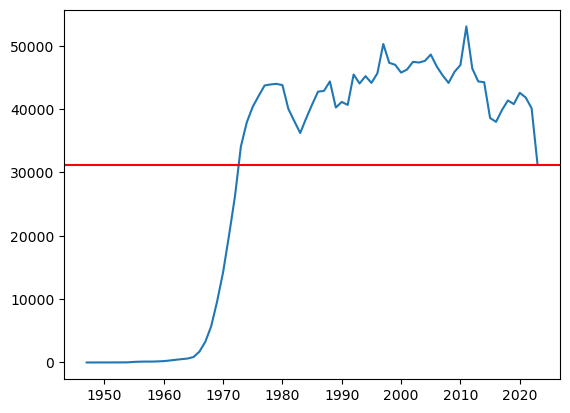

In [29]:
# ...
fil_ngc = ngc[ngc["Periods"].str.contains("JJ")]
y = fil_ngc["TotalSupply_1"]
x = fil_ngc["date"]
# x = ngc.loc["JJ" in df["Periods"]]["date"]
# print(x)
plt.plot(x,y)
plt.axhline(y = y.iloc[-1], color = 'r', linestyle = '-') 

2. The import/export variables are those with names starting with `Import` and `Export`. Plot `TotalSupply_1` against `date` for all import/export variables (Hint: reshape data). Make sure the legend is correctly placed. Set X and Y axis labels to `Year` and `Natural gas (MCM)` respectively and set legend's label to `Import/Export`.


In [31]:
# ...
df3 = ngc.filter(regex='Imports|Exports|date|TotalSupply_1')
df3.head(3)

,date,TotalSupply_1,ImportsOfGaseousNaturalGasTotal_4,ImportsViaNorway_5,ImportsViaGermany_6,ImportsViaBelgium_7,ImportsViaUnitedKingdom_8,ImportsViaDenmark_9,ImportsOfLiquefiedNaturalGasLng_10,ExportsOfGaseousNaturalGasTotal_11,ExportsToNorway_12,ExportsToGermany_13,ExportsToBelgium_14,ExportsToUnitedKingdom_15,ExportsToDenmark_16,ExportsOfLiquefiedNaturalGasLng_17
0,1946-12-31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1947-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1948-12-31,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



3. Plot (point and lines) `TotalSupply_1` against `month` of all time. Note that you will need to summarise (use groupby/sum) on months of the entire dataset. Set X and Y axis labels to `Month` and `Natural gas (MCM)` respectively. Set `Month` axis ticks to represent month abbreviations. Hint: use calendar module to get month abbreviations. Hint: use the `term` variable to filter only `MM` observations.

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


C:\Users\bearb\AppData\Local\Temp\ipykernel_39304\850725373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Periods=df2.Periods.str[4:]


[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Natural Gas (MCM)')]

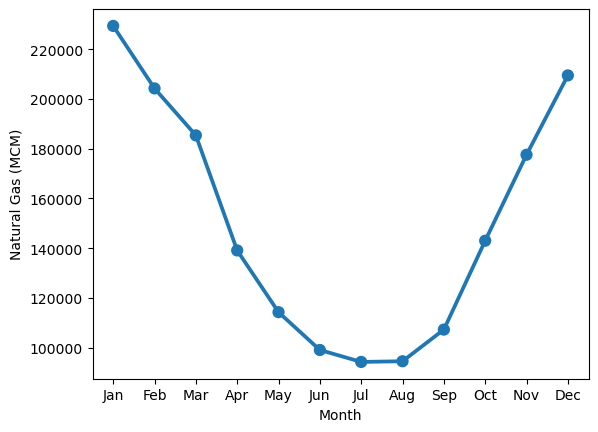

In [85]:
# ...
# fil_ngc = ngc[ngc["Periods"].str.contains("MM")]
fil_ngc = ngc[ngc["term"]== "MM"]
fil_ngc
df2 = fil_ngc[["Periods","TotalSupply_1","year"]]
# df2.TotalSupply_1
df2.Periods=df2.Periods.str[4:]
df_wide = df2.pivot(index='year',columns='Periods', values='TotalSupply_1')
y = df_wide.sum()
import calendar
x = list(calendar.month_abbr)[1:]
print(x)
# sb.lineplot(x=x,y=y)
# sb.scatterplot(x=x,y=y)
ax = sb.pointplot(x=x,y=y)
ax.set(xlabel='Month', ylabel='Natural Gas (MCM)')
# df2.replace(df2["Periods"],df2["Periods"][4:])
# df2

4. Plot boxplots of `TotalSupply_1` against `month` of all time. Set X and Y axis labels to `Month` and `Natural gas (MCM)` respectively. Set `Month` axis ticks to represent month abbreviations.

C:\Users\bearb\AppData\Local\Temp\ipykernel_39304\1865112909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Periods=df2.Periods.str[4:]


[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

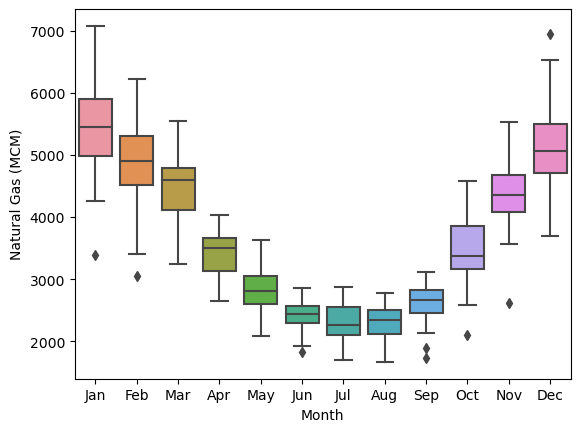

In [91]:
# ...
fil_ngc = ngc[ngc["term"]== "MM"]
df2 = fil_ngc[["Periods","TotalSupply_1","year"]]
df2.Periods=df2.Periods.str[4:]
df_wide = df2.pivot(index='year',columns='Periods', values='TotalSupply_1')
import calendar
x = list(calendar.month_abbr)[1:]
ax = sb.boxplot(df_wide)
ax.set(xlabel='Month', ylabel='Natural Gas (MCM)')
ax.set_xticklabels(x)

5) Boxplots of import/export variables against `TotalSupply_1`. Set X and Y axis labels to `Natural gas (MCM)` and `Import/Export` respectively.

In [ ]:
# ...